In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
#Returns a numpy array with size nrows x ncolumns-1. nrows and ncolums are the rows and columns of the dataset
#the Date column is skipped (ncolumns-1)
def readData(fname):
    with open(fname) as f:
        fileData = f.read()
  
    lines = fileData.split("\n")
    header = lines[0].split(",")
    lines = lines[1:] 
    #print(header) 
    #print("Data rows: ", len(lines))

    rawData = np.zeros((len(lines), len(header)-1)) #skip the Date column

    for i, aLine in enumerate(lines):       
        splittedLine = aLine.split(",")[:]
        rawData[i, 0] = splittedLine[0]
        rawData[i, 1:] = [float(x) for x in splittedLine[2:]] 

    return rawData

In [3]:
#Returns the train and test data, normalized. It also returns the standard deviation of Weekly_Sales
#Each list has a size equal to the number of stores
#For each store there is a list of size trainNSamples (testNSamples) x nColums-1 (the store id is skipped)
#Columns: Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
def splitTrainTest(rawData, testPercent):

    listStore = np.unique(rawData[:, 0])
    trainNSamples = np.zeros(len(listStore))
    
    for i, storeId in enumerate(listStore):
        trainNSamples[i] = np.count_nonzero(rawData[:, 0] == storeId)
    trainNSamples = np.floor((1-testPercent) *  trainNSamples)

    tmpTrain = np.zeros((int(np.sum(trainNSamples)), len(rawData[0])))

    store = -1
    counter = 0
    counterTrain = 0
    storeDict = dict(zip(listStore, trainNSamples))
    for i, aLine in enumerate(rawData):
        if store != aLine[0]:
            store = int(aLine[0])
            counter = 0
        if(counter < storeDict.get(store)):
            tmpTrain[counterTrain] = rawData[i][:]
            counterTrain += 1
            counter += 1

    meanData = tmpTrain.mean(axis=0)
    stdData = tmpTrain.std(axis=0)
    rawNormData = (rawData - meanData) / stdData

    allTrain = list()
    allTest = list()
    store = -1
    counter = 0
    for i, aLine in enumerate(rawNormData):
        splittedLine = [float(x) for x in aLine[1:]] #skip store id
        if store != rawData[i][0]:
            if i != 0:
                allTrain.append(storeDataTrain)
                allTest.append(storeDataTest)
            store = int(rawData[i][0])
            storeDataTrain = list()
            storeDataTest = list()
            counter = 0

        if(counter < storeDict.get(store)):
            storeDataTrain.append(splittedLine)
            counter += 1
        else:
            storeDataTest.append(splittedLine)

        if i == len(rawNormData)-1:
            allTrain.append(storeDataTrain)
            allTest.append(storeDataTest)

    return allTrain, allTest, stdData[1] #std of wSales

In [4]:
#generates a time series given the input and ouput data, the sequence length and the batch size
#seqLength is the number of weeks (observations) of data to be used as input
#the target will be the weekly sales in 2 weeks
def generateTimeSeries(data, wSales, seqLength, batchSize):   
    sampling_rate = 1 #keep all the data points 
    weeksInAdvance = 3
    delay = sampling_rate * (seqLength + weeksInAdvance - 1) #the target will be the weekly sales in 2 weeks
    
    dataset = keras.utils.timeseries_dataset_from_array(
        data[:-delay],
        targets=wSales[delay:],
        sampling_rate=sampling_rate,
        sequence_length=seqLength,
        shuffle=True,
        batch_size=batchSize,
        start_index=0)
    
    return dataset


In [5]:
def printTimeSeriesList(theList):
    print('list length', len(theList))
    print('First element')
    input, target = theList[0]
    print([float(x) for x in input.numpy().flatten()], [float(x) for x in target.numpy().flatten()])
    print('Last element')
    input, target = theList[-1]
    print([float(x) for x in input.numpy().flatten()], [float(x) for x in target.numpy().flatten()])

In [6]:
#returns the training and test time series
#it also returns the standard deviation of Weekly_Sales, and the number of input features
def generateTrainTestData(fileName, testPercent, seqLength, batchSize):
    rawData = readData(os.path.join(fileName))
    allTrain, allTest, stdSales = splitTrainTest(rawData, testPercent)
    
    for i in range(len(allTrain)):
        tmp_train = generateTimeSeries(np.array(allTrain[i]), np.array(allTrain[i])[:,0], seqLength, batchSize)
        tmp_test = generateTimeSeries(np.array(allTest[i]), np.array(allTest[i])[:,0], seqLength, batchSize)

        if i == 0:
            train_dataset = tmp_train
            test_dataset = tmp_test
        else:
            train_dataset = train_dataset.concatenate(tmp_train)
            test_dataset = test_dataset.concatenate(tmp_test)
    
    return train_dataset, test_dataset, stdSales, np.shape(allTrain)[2]

In [7]:
#generateTrainTestData(fileName, testPercent, seqLength, batchSize):
#trainData, testData: each element comes from keras.utils.timeseries_dataset_from_array, i.e., is a time series
#Columns: Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment

testPercent = 0.2
seqLength = 8
batchSize = 1
trainData, testData, stdSales, nFeatures = generateTrainTestData("data/walmart-sales-dataset-of-45stores.csv",
    testPercent, seqLength, batchSize) 

2023-03-31 08:50:26.901331: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-31 08:50:27.028087: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-03-31 08:50:27.028108: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-31 08:50:27.029731: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

# Basic RNN

In [29]:
inputs = keras.Input(shape=(seqLength, 6))

x = layers.SimpleRNN(32)(inputs)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("models/walmart_basic_rnn.keras", save_best_only=True, monitor="val_loss")
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

#print the model summary
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1248      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(trainData,
                    epochs=20,
                    validation_data=testData,
                    callbacks=callbacks)

#model = keras.models.load_model("walmart_basic_rnn.keras") 
#print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
4365/4365 [==============================] - 10s 2ms/step - loss: 0.1216 - mae: 0.2162 - val_loss: 0.2524 - val_mae: 0.4129
Epoch 2/20
4365/4365 [==============================] - 10s 2ms/step - loss: 0.0734 - mae: 0.1748 - val_loss: 0.1037 - val_mae: 0.2603
Epoch 3/20
4365/4365 [==============================] - 10s 2ms/step - loss: 0.0587 - mae: 0.1595 - val_loss: 0.0938 - val_mae: 0.2314
Epoch 4/20
4365/4365 [==============================] - 10s 2ms/step - loss: 0.0509 - mae: 0.1480 - val_loss: 0.0976 - val_mae: 0.2393
Epoch 5/20
4365/4365 [==============================] - 10s 2ms/step - loss: 0.0474 - mae: 0.1436 - val_loss: 0.0925 - val_mae: 0.2332
Epoch 6/20
4365/4365 [==============================] - 10s 2ms/step - loss: 0.0449 - mae: 0.1394 - val_loss: 0.0685 - val_mae: 0.2037
Epoch 7/20
4365/4365 [==============================] - 10s 2ms/step - loss: 0.0436 - mae: 0.1357 - val_loss: 0.0701 - val_mae: 0.2038
Epoch 8/20
4365/4365 [==============================] -

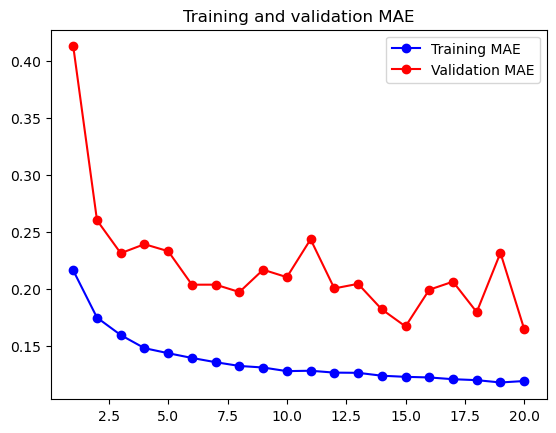

Lowest validation MAE:  94246.7993895874


In [31]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training MAE")
plt.plot(epochs, val_loss, "r-o", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

print("Lowest validation MAE: ", min(val_loss) * stdSales)

# Recurrent Dropout

In [54]:
inputs = keras.Input(shape=(seqLength, 6))

x = layers.LSTM(32, recurrent_dropout=0.10)(inputs)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("models/walmart_recurrent_rnn.keras", save_best_only=True, monitor="val_loss")
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

#print the model summary
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 8, 6)]            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                4992      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = model.fit(trainData,
                    epochs=10,
                    validation_data=testData,
                    callbacks=callbacks)

Epoch 1/10
4365/4365 [==============================] - 45s 10ms/step - loss: 0.1378 - mae: 0.2369 - val_loss: 0.2208 - val_mae: 0.3688
Epoch 2/10
4365/4365 [==============================] - 59s 13ms/step - loss: 0.0987 - mae: 0.2005 - val_loss: 0.1454 - val_mae: 0.2929
Epoch 3/10
4365/4365 [==============================] - 63s 14ms/step - loss: 0.0889 - mae: 0.1929 - val_loss: 0.1852 - val_mae: 0.3342
Epoch 4/10
4365/4365 [==============================] - 79s 18ms/step - loss: 0.0846 - mae: 0.1882 - val_loss: 0.2024 - val_mae: 0.3411
Epoch 5/10
4365/4365 [==============================] - 88s 20ms/step - loss: 0.0751 - mae: 0.1790 - val_loss: 0.1428 - val_mae: 0.2778
Epoch 6/10
4365/4365 [==============================] - 93s 21ms/step - loss: 0.0687 - mae: 0.1744 - val_loss: 0.1284 - val_mae: 0.2623
Epoch 7/10
4365/4365 [==============================] - 80s 18ms/step - loss: 0.0627 - mae: 0.1698 - val_loss: 0.1077 - val_mae: 0.2381
Epoch 8/10
4365/4365 [==========================

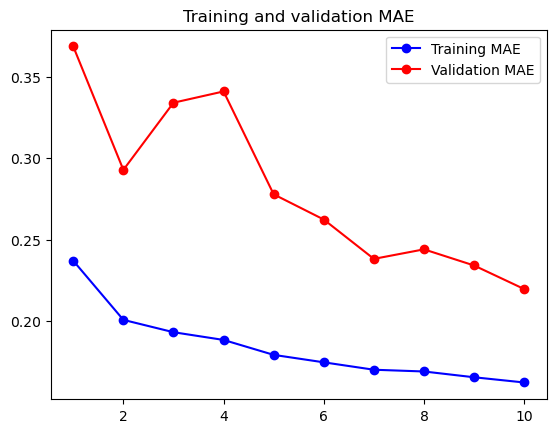

Lowest validation MAE:  125524.5131862228


In [56]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training MAE")
plt.plot(epochs, val_loss, "r-o", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

print("Lowest validation MAE: ", min(val_loss) * stdSales)

# Stacking Recurrent Layers

In [27]:
inputs = keras.Input(shape=(seqLength, 6))

x = layers.GRU(32, recurrent_dropout=0.15, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.15)(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("models/walmart_stacked_rnn.keras", save_best_only=True, monitor="val_loss")
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

#print the model summary
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 gru_10 (GRU)                (None, 8, 32)             3840      
                                                                 
 gru_11 (GRU)                (None, 32)                6336      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10,209
Trainable params: 10,209
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(trainData,
                    epochs=20,
                    validation_data=testData,
                    callbacks=callbacks)

Epoch 1/20
4365/4365 [==============================] - 34s 7ms/step - loss: 0.1307 - mae: 0.2321 - val_loss: 0.1615 - val_mae: 0.3111
Epoch 2/20
4365/4365 [==============================] - 32s 7ms/step - loss: 0.0806 - mae: 0.1842 - val_loss: 0.1384 - val_mae: 0.2757
Epoch 3/20
4365/4365 [==============================] - 32s 7ms/step - loss: 0.0633 - mae: 0.1677 - val_loss: 0.1239 - val_mae: 0.2551
Epoch 4/20
4365/4365 [==============================] - 32s 7ms/step - loss: 0.0614 - mae: 0.1629 - val_loss: 0.0783 - val_mae: 0.1976
Epoch 5/20
4365/4365 [==============================] - 32s 7ms/step - loss: 0.0569 - mae: 0.1563 - val_loss: 0.1120 - val_mae: 0.2333
Epoch 6/20
4365/4365 [==============================] - 31s 7ms/step - loss: 0.0573 - mae: 0.1570 - val_loss: 0.1061 - val_mae: 0.2345
Epoch 7/20
4365/4365 [==============================] - 32s 7ms/step - loss: 0.0556 - mae: 0.1567 - val_loss: 0.1182 - val_mae: 0.2402
Epoch 8/20
4365/4365 [==============================] -

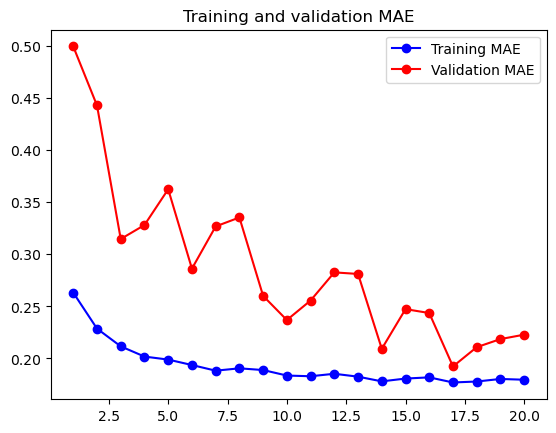

Lowest validation MAE:  109992.36427037478


In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training MAE")
plt.plot(epochs, val_loss, "r-o", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

print("Lowest validation MAE: ", min(val_loss) * stdSales)

# Bidirectional RNNs

In [19]:
inputs = keras.Input(shape=(seqLength, 6))

x = layers.Bidirectional(layers.LSTM(32))(inputs)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("models/walmart_bidirectional_rnn.keras", save_best_only=True, monitor="val_loss")
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

#print the model summary
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 8, 64)            9984      
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 8, 64)            24832     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                           

In [20]:
history = model.fit(trainData,
                    epochs=10,
                    validation_data=testData,
                    callbacks=callbacks)

Epoch 1/10
4365/4365 [==============================] - 38s 7ms/step - loss: 0.1127 - mae: 0.1976 - val_loss: 0.3889 - val_mae: 0.5011
Epoch 2/10
4365/4365 [==============================] - 31s 7ms/step - loss: 0.0782 - mae: 0.1669 - val_loss: 0.3044 - val_mae: 0.4309
Epoch 3/10
4365/4365 [==============================] - 31s 7ms/step - loss: 0.0582 - mae: 0.1470 - val_loss: 0.3107 - val_mae: 0.4328
Epoch 4/10
4365/4365 [==============================] - 31s 7ms/step - loss: 0.0464 - mae: 0.1352 - val_loss: 0.2355 - val_mae: 0.3678
Epoch 5/10
4365/4365 [==============================] - 31s 7ms/step - loss: 0.0414 - mae: 0.1295 - val_loss: 0.2166 - val_mae: 0.3514
Epoch 6/10
4365/4365 [==============================] - 31s 7ms/step - loss: 0.0366 - mae: 0.1245 - val_loss: 0.1679 - val_mae: 0.3101
Epoch 7/10
4365/4365 [==============================] - 31s 7ms/step - loss: 0.0364 - mae: 0.1239 - val_loss: 0.1873 - val_mae: 0.3371
Epoch 8/10
4365/4365 [==============================] -

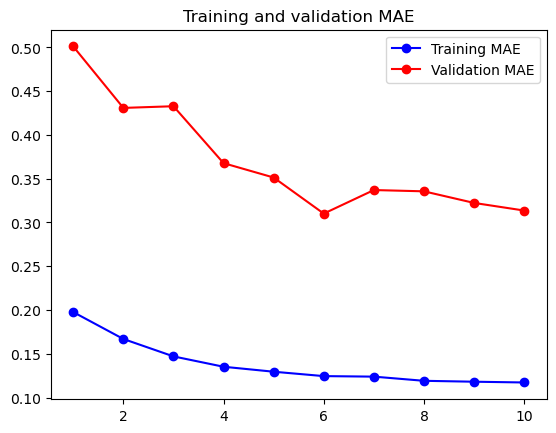

Lowest validation MAE:  177359.48039462755


In [21]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training MAE")
plt.plot(epochs, val_loss, "r-o", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

print("Lowest validation MAE: ", min(val_loss) * stdSales)